In [1]:
import h5py
import ROOT

import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp

from tqdm import tqdm
from itertools import repeat

ROOT.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/')
ROOT.gROOT.ProcessLine('.include /usr/local/Delphes-3.4.2/external/')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootTreeReader.h"')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootConfReader.h"')
ROOT.gInterpreter.Declare('#include "/usr/local/Delphes-3.4.2/external/ExRootAnalysis/ExRootTask.h"')
ROOT.gSystem.Load("/usr/local/Delphes-3.4.2/install/lib/libDelphes")

MAX_JETS = 300
N_CORES = 8

Welcome to JupyROOT 6.20/08


In [2]:
def Mjets(*arg):
    # arg: list of jets
    # return: invariant mass of jets
    e_tot, px_tot, py_tot, pz_tot = 0, 0, 0, 0
    
    for jet in arg:
        pt, eta, phi, m = jet[0], jet[1], jet[2], jet[3]
        
        px, py, pz = pt*np.cos(phi), pt*np.sin(phi), pt*np.sinh(eta)
        e = np.sqrt(m**2 + px**2 + py**2 + pz**2)
        
        px_tot += px
        py_tot += py
        pz_tot += pz
        e_tot += e
    
    return np.sqrt(e_tot**2 - px_tot**2 - py_tot**2 - pz_tot**2)

# Basic Information

In [3]:
def get_number_of_constituents(tree):
    # Hidden Valley model selection
    # 1. 2 jets
    # 2. pT > 750 GeV
    # 3. |eta| < 2.0
    # 4. 4300 < Mjj < 5900 GeV
    
    n_consti = [[],[]]

    for event_id, event in tqdm(enumerate(tree)):

        if event.Jet_size < 2:
            continue

        if event.Jet[1].PT < 750:
            continue

        if abs(event.Jet[0].Eta) > 2.0 or abs(event.Jet[1].Eta) > 2.0:
            continue

        jets = [[event.Jet[i].PT, event.Jet[i].Eta, event.Jet[i].Phi, event.Jet[i].Mass] for i in range(2)]
        mjj = Mjets(*jets)

        if mjj < 4300 or mjj > 5900:
            continue

        # Get number of constituents
        constituents = [consti for consti in event.Jet[0].Constituents if consti != 0]
        n_consti[0].append(len(constituents))

        constituents = [consti for consti in event.Jet[1].Constituents if consti != 0]
        n_consti[1].append(len(constituents))

    return n_consti

In [4]:
root_file = '../../Software/pythia8307/HVmodel/test_100k.root'
f = ROOT.TFile(root_file)
tree_s = f.Get("Delphes")

n_consti_s = get_number_of_constituents(tree_s)

100000it [03:15, 511.12it/s]


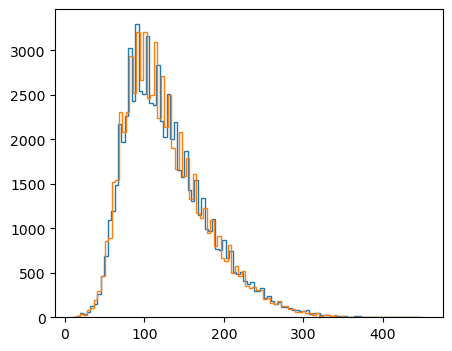

In [5]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.hist(n_consti_s[0], bins=100, histtype='step')
ax.hist(n_consti_s[1], bins=100, histtype='step')
plt.show()

# From .root to .h5

In [3]:
# HDF5
def create_dataset(f, nevent, MAX_JETS):

    f.create_dataset('J1/MASK', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='|b1')
    f.create_dataset('J1/pt', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='<f4')
    f.create_dataset('J1/eta', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='<f4')
    f.create_dataset('J1/phi', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='<f4')

    f.create_dataset('J2/MASK', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='|b1')
    f.create_dataset('J2/pt', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='<f4')
    f.create_dataset('J2/eta', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='<f4')
    f.create_dataset('J2/phi', (nevent, MAX_JETS), maxshape=(None, MAX_JETS), dtype='<f4')

    f.create_dataset('EVENT/Mjj', (nevent,), maxshape=(None,), dtype='<f4')
    f.create_dataset('EVENT/signal', (nevent,), maxshape=(None,), dtype='<i8')


def write_dataset(file, data: list):
    nevent = len(data)
    
    for key in data[0].keys():
        # Resize
        shape = list(file[key].shape)
        shape[0] = nevent
        file[key].resize(shape)
        # Write
        value = np.array([data_dict[key] for data_dict in data])
        file[key][:] = value


def get_dataset_keys(f):
    keys = []
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    return keys


In [4]:
def get_pt_eta_phi(constituents):
    pts = np.array([consti.PT if hasattr(consti, 'PT') else consti.ET for consti in constituents])
    etas = np.array([consti.Eta for consti in constituents])
    phis = np.array([consti.Phi for consti in constituents])
    return pts, etas, phis


def select_event(root_path, sample_type, start, end):
    # Hidden Valley model selection
    # 1. 2 jets
    # 2. pT > 750 GeV
    # 3. |eta| < 2.0
    # 4. 4300 < Mjj < 5900 GeV

    f = ROOT.TFile(root_path)
    tree = f.Get("Delphes")

    data_list = []
    for i in tqdm(range(start, end)):
        tree.GetEntry(i)

        if tree.Jet_size < 2:
            continue

        if tree.Jet[1].PT < 750:
            continue

        if abs(tree.Jet[0].Eta) > 2.0 or abs(tree.Jet[1].Eta) > 2.0:
            continue

        jets = [[tree.Jet[i].PT, tree.Jet[i].Eta, tree.Jet[i].Phi, tree.Jet[i].Mass] for i in range(2)]
        mjj = Mjets(*jets)

        if mjj < 4300 or mjj > 5900:
            continue

        # get jet constituents
        constituents = [consti for consti in tree.Jet[0].Constituents if consti != 0]
        n_consti_1 = len(constituents)
        PT1, Eta1, Phi1 = get_pt_eta_phi(constituents)

        constituents = [consti for consti in tree.Jet[1].Constituents if consti != 0]
        n_consti_2 = len(constituents)
        PT2, Eta2, Phi2 = get_pt_eta_phi(constituents)

        if n_consti_1 < 5 or n_consti_2 < 5:
            continue

        # 準備寫入資料
        data_dict = {
            'J1/MASK': np.arange(MAX_JETS) < n_consti_1,
            'J1/pt': PT1[:MAX_JETS] if n_consti_1 > MAX_JETS else np.pad(PT1, (0, MAX_JETS-n_consti_1)),
            'J1/eta': Eta1[:MAX_JETS] if n_consti_1 > MAX_JETS else np.pad(Eta1, (0, MAX_JETS-n_consti_1)),
            'J1/phi': Phi1[:MAX_JETS] if n_consti_1 > MAX_JETS else np.pad(Phi1, (0, MAX_JETS-n_consti_1)),

            'J2/MASK': np.arange(MAX_JETS) < n_consti_2,
            'J2/pt': PT2[:MAX_JETS] if n_consti_2 > MAX_JETS else np.pad(PT2, (0, MAX_JETS-n_consti_2)),
            'J2/eta': Eta2[:MAX_JETS] if n_consti_2 > MAX_JETS else np.pad(Eta2, (0, MAX_JETS-n_consti_2)),
            'J2/phi': Phi2[:MAX_JETS] if n_consti_2 > MAX_JETS else np.pad(Phi2, (0, MAX_JETS-n_consti_2)),

            'EVENT/Mjj': mjj,
            'EVENT/signal': sample_type,
        }
        data_list.append(data_dict)

    return data_list


def from_root_to_h5(root_path, output_path, sample_type):
    # Select events and save the jets information to h5 file

    # Get number of events
    f = ROOT.TFile(root_path)
    nevent = f.Get("Delphes").GetEntries()
    print(f'Number of events: {nevent}')

    # Multi-core processing
    print(f'Number of cores: {N_CORES}')
    start = [nevent // N_CORES * i for i in range(N_CORES)]
    end = [nevent // N_CORES * (i+1) for i in range(N_CORES)]
    end[-1] = nevent

    with mp.Pool(processes=N_CORES) as pool:
        results = pool.starmap(select_event, zip(repeat(root_path), repeat(sample_type), start, end))
    data_list = [data_dict for result_list in results for data_dict in result_list]

    # write to h5 file
    with h5py.File(output_path, 'w') as f_out:
        create_dataset(f_out, nevent, MAX_JETS)
        write_dataset(f_out, data_list)

In [6]:
root_file = '../../Software/pythia8307/HVmodel/test.root'
output_path = './HVmodel/data/test-new.h5'
sample_type = 1

from_root_to_h5(root_file, output_path, sample_type)

Number of events: 10000
Number of cores: 8


100%|██████████| 1250/1250 [00:03<00:00, 366.93it/s]
